# Exercise 13: Structured light

## Helper functions

In [77]:
import numpy as np
import cv2 
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib
import skimage

def load_im(path : str, greyscale : bool) -> np.ndarray:
    """
        Takes:
            :param path: Path to where the image should be loaded
            :param greyscale: A flag that determines whether the image should be loaded as greyscale or not
            
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    if greyscale:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    return im


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom


def hest(q1, q2) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x)) # <-- formula follows that of week 2, slide 56
        # print(np.kron(q2t_hom.T, q1x).shape)
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    
def crossOp(p : np.ndarray) -> np.ndarray:
    """
        One of Them weird functions. It takes in a 3D vector and then returns
        some gnarly matrix.
    """
    p = p.flatten()
    if p.size != 3:
        raise Exception("Invalid input, vector must be exactly 3D.")
    
    x, y, z = p
    px = np.array(
        [[0, -z, y],
         [z, 0, -x],
         [-y, x, 0]]
    )
    
    return px


def computeFundamentalMatrix(K1 : np.ndarray, K2 : np.ndarray, R2 : np.ndarray, t2 : np.ndarray) -> np.ndarray:
    """
        Computing the fundamental matrix between two camera matrices K1 & K2.
    """
    t2x = crossOp(t2)

    E = t2x @ R2

    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)

    F = K1inv.T @ E @ K2inv
    
    return F


def fancyRotate(theta_x, theta_y, theta_z):
    """
        Does the rotation matrix that we have seen a few times.
        E.g. Exercises week 4, eq(12).
    """
    from scipy.spatial.transform import Rotation
    
    R = Rotation.from_euler("xyz", [theta_x, theta_y, theta_z]).as_matrix()
    
    return R


def in_frame(l, l_im, shape):
    """
        I think this checks whether the line is within the image
    """
    q = np.cross(l.flatten(), l_im)
    q = q[:2]/q[2]
    if all(q >= 0) and all(q+1 <= shape[1::-1]):
        return q
  
    
def DrawLine(l, shape):
    """
        Checks where the line intersects the four sides of the image
        and finds the two intersections that are within the frame
    """
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l, l_im, shape) for l_im in lines if in_frame(l, l_im, shape) is not None]
    plt.plot(*np.array(P).T)


def draw_line_Vitus(line: np.ndarray, tau: float):
    """
        Draws a line with a width of tau.
        
        Takes:
            :param line: The line to be drawn
            :param tau: The distance from the line to be drawn
        
        Returns:
            :return: None
    """
    
    x1, x2 = plt.gca().get_xlim()
    y1 = -(line[0]*x1 + line[2]) / line[1]
    y2 = -(line[0]*x2 + line[2]) / line[1]
    y1_low = -(line[0]*x1 + line[2] + tau) / line[1]
    y1_high = -(line[0]*x1 + line[2] - tau) / line[1]
    y2_low = -(line[0]*x2 + line[2] + tau) / line[1]
    y2_high = -(line[0]*x2 + line[2] - tau) / line[1]
    
    plt.axline((x1,y1), (x2,y2), c='black')
    plt.axline((x1,y1_low), (x2,y2_low), c='black', linestyle='dashed')
    plt.axline((x1,y1_high), (x2,y2_high), c='black', linestyle='dashed')


def triangulate(q_thicc : list, P_thicc : list):
    """
        Should take in:
            A list of n pixel-coordinates: [q1, q2, ..., qn]
            
            A list of n projection matrices: [P1, P2, ..., Pn]
        
        And return:
            The triangulation of the 3D point by utilizing the linear algorithm.
    """
    
    n = len(P_thicc)
    m = P_thicc[0].shape[1]
    
    B = np.zeros((2*n, m))
    
    for i in range(n):
        Pi = P_thicc[i]
        x, y = q_thicc[i]
        x, y = x.item(), y.item()   # <-- apparently there could be some issues with indexing of arrays
        
        B[i*2] = Pi[2] * x - Pi[0]
        B[i * 2 + 1] = Pi[2] * y - Pi[1]
        
    u, s, vh = np.linalg.svd(B)
    v = vh.T
    Q = v[:, -1]
    
    Q = Q.T / Q[-1] # <-- This scaling was highly recommended by Andreas <3
    
    return Q



## Loading Casper

In [78]:
CASPER_PATH = "../Data/Week_13/"
c = np.load(CASPER_PATH + "calib.npy", allow_pickle=True).item()



## Loading images

## Ex. 13.1

If the cameras were not calibrated, you would need to calibrate them first.

How would you find their intrinsics?

What about the extrinsics?


### Response

## Ex. 13.2

First we need to rectify the images. First run the following code to initialize the maps for rectification:

```
im0 = cv2.imread("sequence/frames0_0.png")

size = (im0.shape[1], im0.shape[0])

stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'], c['d1'], size, c['R'], c['t'], flags=0)

R0, R1, P0, P1 = stereo[:4]

maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)

maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

```

You can now rectify images by doing `cv2.remap(im, *maps, cv2.INTER_LINEAR)`, where `maps` is either `maps0` or `maps1` depending on which camera the image is coming from. This also handles the undistortion of the images. `P0` and `P1` are the projection matrices for the rectified images, which will come in handy when we need to triangulate the points in **3D**.

Now for each image,

* Load it,
* Convert it floating point and grey-scale, and
* rectifiy it.

Store the resulting images in two lists (`ims0` and `ims1`), one for each camera.

Show `ims0[0]` and `ims1[0]` side-by-side and verify visually that the images have been rectified.



### Response

#### The code of Morten

In [79]:
CASPER_PATH = "../Data/Week_13/"

im0 = cv2.imread(CASPER_PATH + "sequence/frames0_0.png")

size = (im0.shape[1], im0.shape[0])

stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'], c['d1'], size, c['R'], c['t'], flags=0)

R0, R1, P0, P1 = stereo[:4]

NUM_MAPS = 2

maps = [None] * NUM_MAPS   # <-- This is just for initialization - a list of two elements

maps[0] = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps[1] = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)


#### ReMapping

In [80]:
NUM_IMS = 25

ims = [[],[]]
# We skip the first two images, because they are something which is fully illuminated and something which is fully dark
for i in range(NUM_IMS + 1):
    # There are two maps
    for j in range(2):
        filename = CASPER_PATH + f"sequence/frames{j}_{i}.png"
        im = load_im(filename)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_remap = cv2.remap(im, map1 = maps[j][0], map2 = maps[j][1], interpolation = cv2.INTER_LINEAR)
        # print(f"ReMapped: '{filename}'")
        ims[j].append(im_remap)

ims0, ims1 = ims
    

In [81]:
print(len(ims0))

26


#### Showing some of the images

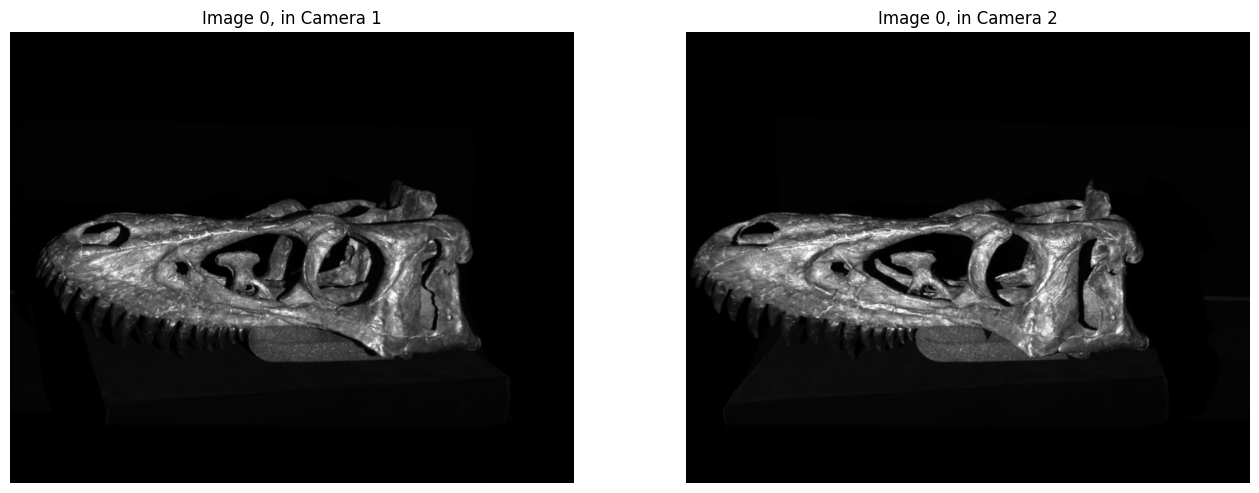

In [82]:
IM_TO_SHOW = 0 

plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.title(f"Image {IM_TO_SHOW}, in Camera 1")
plt.axis("off")
plt.imshow(ims0[IM_TO_SHOW], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"Image {IM_TO_SHOW}, in Camera 2")
plt.axis("off")
plt.imshow(ims1[IM_TO_SHOW], cmap="gray")

plt.show()

## Ex. 13.3

At this point, we are ready to make a function that can compute the phases for each camera `theta = unwrap(ims)`. I suggest to write the code for camera 0 and to put it into a function once it’s working.

Use indexing to get a list of the primary images out, and make sure it has length 16. Put this list into the **Fast Fourier Transform** (`np.fft.rfft`) to find the Fourier spectrums of the primary images (`fft_primary`). We use `rfft` as the input is only real numbers. The function can operate on a list of arrays, which is ideal for our situation. Make sure to specify that the FFT should operate along the first dimension of the array (`axis=0`).

The Fourier component corresponding to the pattern is in the second component (`fft_primary[1]`). Get the phase of this using `np.angle` and call it `theta_primary`.

Repeat the same steps for the secondary phase to obtain `theta_secondary`. Compute the phase cue (`theta_c`) using the heterodyne principle.

Find the order (`o_primary`) of the primary phase.

Use the order of the primary phase to obtain the unwrapped phase (`theta`).

Wrap all of the above into a function `theta = unwrap(ims)` and use it to obtain the phase for both cameras (`theta0` and `theta1`).


### Response

In [83]:
def unwrap(ims : list[np.ndarray], n_primary_ims : int, n_secondary_ims : int, n_phases_primary : int, n_phases_secondary : int):
    """
        A function which take in a lists of images and computes the phases
        
        Takes:
            :param im0: A list of the images from camera one of the cameras
            :param n_primary_ims: The number of images in the primary pattern
            :param n_secondary_ims: The number of images in the secondary pattern
            :param n_phases_primary: The number of phases in the primary pattern
            :param n_phases_secondary: The number of phases in the secondary pattern
        
        Returns:
            :return theta_est: The estimated phase
    """
    
    assert n_phases_primary + 1 == n_phases_secondary, "There should be exactly one phase more in the second pattern, otherwise the maths falls apart!"

    # Primary phase
    primary = ims[:n_primary_ims]
    assert len(primary) == n_primary_ims, f"There should be {n_primary_ims} images! There are {len(primary)} images!"

    fft_primary = np.fft.rfft(primary, axis=0)
    fourier_pattern_component_primary = fft_primary[1]
    theta_primary = np.angle(fourier_pattern_component_primary)

    # Secondary phase
    secondary = ims[n_primary_ims:]
    assert len(secondary) == n_secondary_ims, f"There should be {n_secondary_ims} images! There are {len(secondary)} images!"

    fft_secondary = np.fft.rfft(secondary, axis=0)
    fourier_pattern_component_secondary = fft_secondary[1]
    theta_secondary = np.angle(fourier_pattern_component_secondary)

    # Using hetorodyne principle to get theta cue
    theta_c = (theta_secondary - theta_primary) % (2 * np.pi)

    # As per week 13 slide 27
    o_primary = np.round((n_phases_primary * theta_c - theta_primary) / (2 * np.pi))

    # As per week 13 slide 27
    theta_est = ((2 * np.pi * o_primary + theta_primary) / n_phases_primary) % (2 * np.pi)
    
    return theta_est


theta0 = unwrap(ims = ims0[2:], n_primary_ims=16, n_secondary_ims=8, n_phases_primary=40, n_phases_secondary=41)
theta1 = unwrap(ims = ims1[2:], n_primary_ims=16, n_secondary_ims=8, n_phases_primary=40, n_phases_secondary=41)

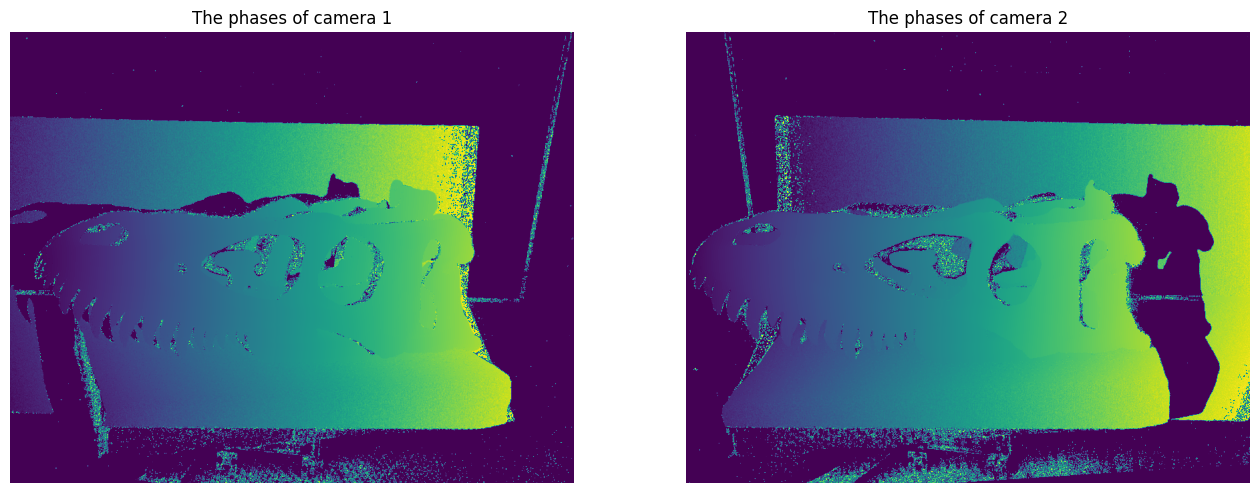

In [84]:
plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.title(f"The phases of camera 1")
plt.axis("off")
plt.imshow(theta0)

plt.subplot(1, 2, 2)
plt.title(f"The phases of camera 2")
plt.axis("off")
plt.imshow(theta1)

plt.show()

## Ex. 13.4

When inspecting the phase images `theta0` and `theta1` it is clear that not all pixels contain a valid measurement of the phase. This is because some pixels do not reflect enough light from the projector to give a meaningful measurement. To fix this we introduce a binary mask that contains the areas that are sufficiently illuminated by the projector. Subtract the fully on and fully off projector image from each other (the first two elements of ims), to obtain a measurement of how much projector light is in each pixel.

Apply a threshold to this difference image to obtain a mask for each camera (`mask0` and `mask1`).
I suggest using a threshold of 15.


### Response

In [85]:
THRESHOLD = 15

mask0 = (ims0[0] - ims0[1]) > THRESHOLD
mask1 = (ims1[0] - ims1[1]) > THRESHOLD

Showing the masks.

(*They are fine*)

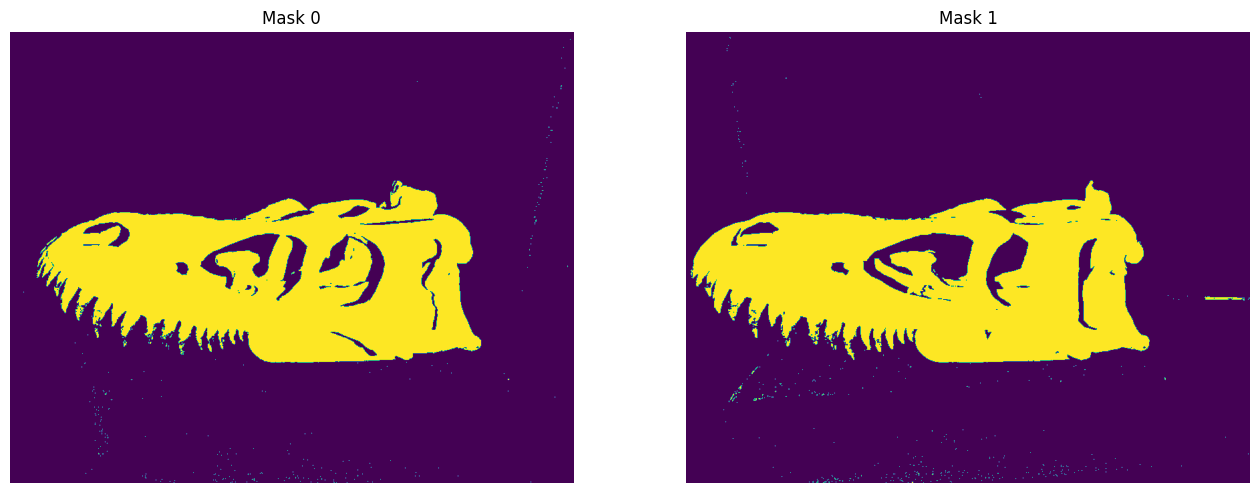

In [86]:
plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.title(f"Mask 0")
plt.axis("off")
plt.imshow(mask0)

plt.subplot(1, 2, 2)
plt.title(f"Mask 1")
plt.axis("off")
plt.imshow(mask1)

plt.show()

## Ex. 13.5

Now we need to find matches between the two cameras. As the images are rectified, we can constrain ourselves to search for a match on the corresponding row in the other image. That is we need to create two lists (`q0s` and `q1s`) that contain the pixel coordinates of matches between
camera 0 and 1.

Use a double for-loop to iterate over all pixels in camera 0. For each valid pixel (`mask0[i0,j0] = True` which has the phase `theta0[i0,j0]`), we need to find the pixel in the other image that matches the best. As the images are rectified the epipolar line is a the row `i0` in camera 1. Thus, we find the matching pixel in camera 1, selecting the pixel from row `i0` which is valid `mask1[i0,j1] = True` and which has the closest phase match: `theta0[i0,j0] ∼ theta1[i0,j1]`.

Be aware that the points have to be of the form *(x, y)* i.e. `[j, i]`, in order to work with our projection matrices.

To verify your matches you can compute the disparity image. This is the image such that `disparity[i0,j0] = j0 - j1` for all valid pixels. Initialize it with 0 everywhere, and fill it where you have matches.

### Response

In [87]:
q0s = []
q1s = []

disparity_im = np.zeros((size[1], size[0]))

inv_mask1 = ~mask1

for i in range(size[1]):
    for j in range(size[0]):
        if mask0[i, j]:
            # Find the closest value in theta1 to theta0[i, j]
            # We know that the closest value is going to be in the same row
            indx = np.ma.masked_array(abs(theta1[i] - theta0[i, j]), inv_mask1[i]).argmin()
            q0s.append([j, i])
            q1s.append([indx, i])
            disparity_im[i, j] = j - indx # <-- Doing the disparity calculation in the for-loop is bigBrains.TM

# Very important that you make these float otherwise CV2 will complain
q0s = np.array(q0s).astype(float).T
q1s = np.array(q1s).astype(float).T
            

In [88]:
print("The boys got roughly the same amount of matches")
print(q0s.shape)
print(q1s.shape)

The boys got roughly the same amount of matches
(2, 111655)
(2, 111655)


Disparity and image

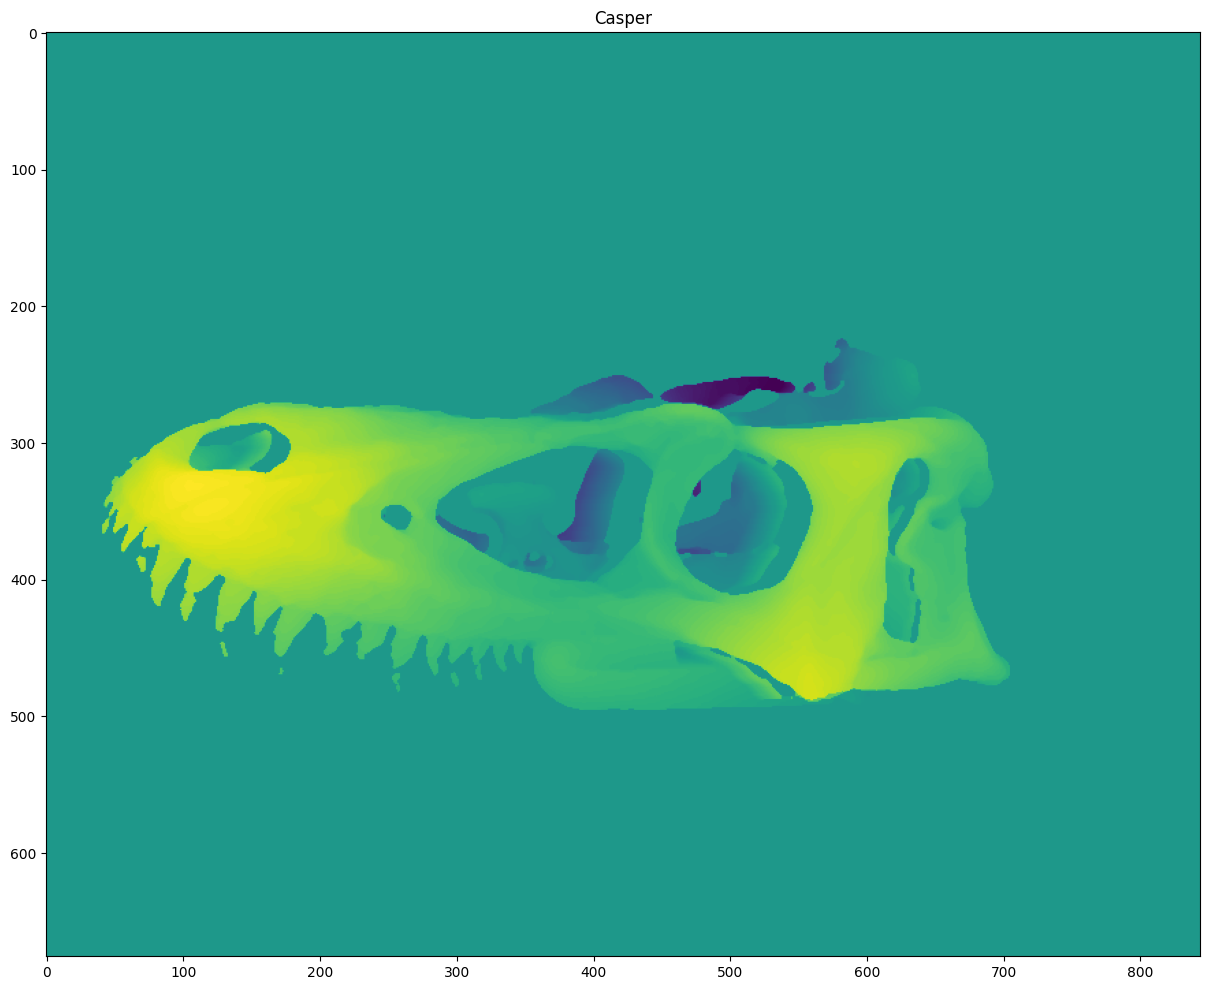

In [89]:
# This is a bit silly, Jonas just did the calculation in the above for loop and it worked fine
"""
disparity_im = np.zeros(size)

for i in range(q0s.shape[0]):
    i0 = q0s[i][0]
    j0 = q0s[i][1]
    j1 = q1s[i][1]
    disparity_im[i0, j0] = j0 - j1
"""

disparity_im = cv2.medianBlur(disparity_im.astype(np.float32), 5)    

plt.figure(figsize=(16, 12))
plt.imshow(disparity_im)
plt.title("Casper")
plt.show()
        

## Ex. 13.6

Finally, use the matches from the previous exercise and triangulate the 3D points, using the projection matrices `P0` and `P1` from Exercise 13.2. To triangulate you can use your own function
or `cv2.triangulatePoints`. For the OpenCV function you need to convert your lists to arrays, transpose them, and convert them to floating point. The output of `cv2.triangulatePoints` is in
homogeneous coordinates.

Remove any points that lie behind the cameras (negative third coordinate of **Q**).

To visualize the points you can use `Open3D`.
Install it with

`pip install open3d`

Visualize your points in 3D by doing (press [ESC] to close the window again)

```
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])
```


### Response

In [90]:
# Triangulate points
Q = pi(cv2.triangulatePoints(P0, P1, q0s, q1s))

Q_shape_prev = Q.shape
print(f"Q shape (before removal of points behind cam): {Q_shape_prev}")

# Remove points behind the camera
Q = Q[:, Q[2] > 0]
Q_shape_post = Q.shape
print(f"Q shape (after removal of points behind cam): {Q_shape_post}")
print(f"Num removed points: {Q_shape_prev[1] - Q_shape_post[1]}")


# Remove points with high reprojection-error
THRESHOLD = 2 # <-- This is a bit arbitrary
"""
inliers0 = np.array([np.linalg.norm(pi(P0@piInv(Qi)) - qi) < THRESHOLD for Qi, qi in zip(Q.T, q0s.T)])
inliers1 = np.array([np.linalg.norm(pi(P1@piInv(Qi)) - qi) < THRESHOLD for Qi, qi in zip(Q.T, q1s.T)])
inliers = inliers0 * inliers1

Q_no_inliers = Q[:, inliers]
"""


Q shape (before removal of points behind cam): (3, 111655)
Q shape (after removal of points behind cam): (3, 111647)
Num removed points: 8


'\ninliers0 = np.array([np.linalg.norm(pi(P0@piInv(Qi)) - qi) < THRESHOLD for Qi, qi in zip(Q.T, q0s.T)])\ninliers1 = np.array([np.linalg.norm(pi(P1@piInv(Qi)) - qi) < THRESHOLD for Qi, qi in zip(Q.T, q1s.T)])\ninliers = inliers0 * inliers1\n\nQ_no_inliers = Q[:, inliers]\n'

Morten's code

In [91]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])

In [92]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q_no_inliers.T)
o3d.visualization.draw_geometries([pcd])

NameError: name 'Q_no_inliers' is not defined